In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import time
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras import layers
from keras import models
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
style_img_path = "data/Renoir/style.png"
style_mask_path = "data/Renoir/style_mask.png"
target_mask_path = "data/Renoir/target_mask.png"
content_img_path = "data/Renoir/creek.jpg"
target_img_prefix = "results"
use_content_img = content_img_path is not None

In [4]:
num_labels = 4
num_colors = 3  # RGB
# determine image sizes based on target_mask
ref_img = img_to_array(load_img(target_mask_path))
img_nrows, img_ncols = ref_img.shape[:2]

num_iterations = 50

total_variation_weight = 50.
style_weight = 1.
content_weight = 0.1 if use_content_img else 0

content_feature_layers = ['block5_conv2']
# To get better generation qualities, use more conv layers for style features
style_feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                        'block4_conv1', 'block5_conv1']

In [5]:
# helper functions for reading/processing images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def kmeans(xs, k):
    assert xs.ndim == 2
    try:
        from sklearn.cluster import k_means
        _, labels, _ = k_means(xs.astype('float64'), k)
    except ImportError:
        from scipy.cluster.vq import kmeans2
        _, labels = kmeans2(xs, k, missing='raise')
    return labels

In [7]:
def load_mask_labels():
    '''Load both target and style masks.
    A mask image (nr x nc) with m labels/colors will be loaded
    as a 4D boolean tensor:
        (1, m, nr, nc) for 'channels_first' or (1, nr, nc, m) for 'channels_last'
    '''
    target_mask_img = load_img(target_mask_path,
                               target_size=(img_nrows, img_ncols))
    target_mask_img = img_to_array(target_mask_img)
    style_mask_img = load_img(style_mask_path,
                              target_size=(img_nrows, img_ncols))
    style_mask_img = img_to_array(style_mask_img)
    mask_vecs = np.vstack([style_mask_img.reshape((-1, 3)),
                           target_mask_img.reshape((-1, 3))])

    labels = kmeans(mask_vecs, num_labels)
    style_mask_label = labels[:img_nrows *
                              img_ncols].reshape((img_nrows, img_ncols))
    target_mask_label = labels[img_nrows *
                               img_ncols:].reshape((img_nrows, img_ncols))

    stack_axis = -1
    style_mask = np.stack([style_mask_label == r for r in range(num_labels)],
                          axis=stack_axis)
    target_mask = np.stack([target_mask_label == r for r in range(num_labels)],
                           axis=stack_axis)

    return (np.expand_dims(style_mask, axis=0),
            np.expand_dims(target_mask, axis=0))

In [8]:
# Create tensor variables for images
shape = (1, img_nrows, img_ncols, num_colors)

style_image = K.variable(preprocess_image(style_img_path))
target_image = K.placeholder(shape=shape)
if use_content_img:
    content_image = K.variable(preprocess_image(content_img_path))
else:
    content_image = K.zeros(shape=shape)
images = K.concatenate([style_image, target_image, content_image], axis=0)

# Create tensor variables for masks
raw_style_mask, raw_target_mask = load_mask_labels()
style_mask = K.variable(raw_style_mask.astype('float32'))
target_mask = K.variable(raw_target_mask.astype('float32'))
masks = K.concatenate([style_mask, target_mask], axis=0)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# index constants for images and tasks variables
STYLE, TARGET, CONTENT = 0, 1, 2

# Build image model, mask model and use layer outputs as features
# image model as VGG19
image_model = vgg19.VGG19(include_top=False, input_tensor=images)

# mask model as a series of pooling
mask_input = layers.Input(tensor=masks, shape=(None, None, None), name='mask_input')
x = mask_input
for layer in image_model.layers[1:]:
    name = 'mask_%s' % layer.name
    if 'conv' in layer.name:
        x = layers.AveragePooling2D((3, 3), padding='same', strides=(1, 1), name=name)(x)
    elif 'pool' in layer.name:
        x = layers.AveragePooling2D((2, 2), name=name)(x)
mask_model = models.Model(mask_input, x)

# Collect features from image_model and task_model
image_features = {}
mask_features = {}
for img_layer, mask_layer in zip(image_model.layers, mask_model.layers):
    if 'conv' in img_layer.name:
        assert 'mask_' + img_layer.name == mask_layer.name
        layer_name = img_layer.name
        img_feat, mask_feat = img_layer.output, mask_layer.output
        image_features[layer_name] = img_feat
        mask_features[layer_name] = mask_feat

In [10]:
# Define loss functions
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(x)
    gram = K.dot(features, K.transpose(features))
    return gram


def region_style_loss(style_image, target_image, style_mask, target_mask):
    '''Calculate style loss between style_image and target_image,
    for one common region specified by their (boolean) masks
    '''
    assert 3 == K.ndim(style_image) == K.ndim(target_image)
    assert 2 == K.ndim(style_mask) == K.ndim(target_mask)
    masked_style = K.permute_dimensions(
        style_image, (2, 0, 1)) * style_mask
    masked_target = K.permute_dimensions(
        target_image, (2, 0, 1)) * target_mask
    num_channels = K.shape(style_image)[-1]
    num_channels = K.cast(num_channels, dtype='float32')
    s = gram_matrix(masked_style) / K.mean(style_mask) / num_channels
    c = gram_matrix(masked_target) / K.mean(target_mask) / num_channels
    return K.mean(K.square(s - c))


def style_loss(style_image, target_image, style_masks, target_masks):
    '''Calculate style loss between style_image and target_image,
    in all regions.
    '''
    assert 3 == K.ndim(style_image) == K.ndim(target_image)
    assert 3 == K.ndim(style_masks) == K.ndim(target_masks)
    loss = K.variable(0)
    for i in range(num_labels):
        style_mask = style_masks[:, :, i]
        target_mask = target_masks[:, :, i]
        loss = loss + region_style_loss(style_image,
                                        target_image,
                                        style_mask,
                                        target_mask)
    return loss


def content_loss(content_image, target_image):
    return K.sum(K.square(target_image - content_image))


def total_variation_loss(x):
    assert 4 == K.ndim(x)
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] -
                 x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] -
                 x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [11]:
# Overall loss is the weighted sum of content_loss, style_loss and tv_loss
# Each individual loss uses features from image/mask models.
loss = K.variable(0)
for layer in content_feature_layers:
    content_feat = image_features[layer][CONTENT, :, :, :]
    target_feat = image_features[layer][TARGET, :, :, :]
    loss = loss + content_weight * content_loss(content_feat, target_feat)

for layer in style_feature_layers:
    style_feat = image_features[layer][STYLE, :, :, :]
    target_feat = image_features[layer][TARGET, :, :, :]
    style_masks = mask_features[layer][STYLE, :, :, :]
    target_masks = mask_features[layer][TARGET, :, :, :]
    sl = style_loss(style_feat, target_feat, style_masks, target_masks)
    loss = loss + (style_weight / len(style_feature_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(target_image)
loss_grads = K.gradients(loss, target_image)

# Evaluator class for computing efficiency
outputs = [loss]
if isinstance(loss_grads, (list, tuple)):
    outputs += loss_grads
else:
    outputs.append(loss_grads)

f_outputs = K.function([target_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [12]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# Generate images by iterative optimization
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

for i in range(num_iterations):
    print('Start of iteration', i, '/', num_iterations)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = target_img_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0 / 50
Current loss value: 8488447600000.0
Image saved as results_at_iteration_0.png
Iteration 0 completed in 5s
Start of iteration 1 / 50
Current loss value: 4678242000000.0
Image saved as results_at_iteration_1.png
Iteration 1 completed in 3s
Start of iteration 2 / 50
Current loss value: 3244179300000.0
Image saved as results_at_iteration_2.png
Iteration 2 completed in 3s
Start of iteration 3 / 50
Current loss value: 2128657000000.0
Image saved as results_at_iteration_3.png
Iteration 3 completed in 3s
Start of iteration 4 / 50
Current loss value: 931647060000.0
Image saved as results_at_iteration_4.png
Iteration 4 completed in 3s
Start of iteration 5 / 50
Current loss value: 477277160000.0
Image saved as results_at_iteration_5.png
Iteration 5 completed in 3s
Start of iteration 6 / 50
Current loss value: 353114880000.0
Image saved as results_at_iteration_6.png
Iteration 6 completed in 3s
Start of iteration 7 / 50
Current loss value: 281804870000.0
Image saved as res

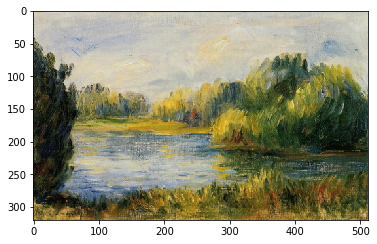

In [13]:
plt.imshow(load_img("data/Renoir/style.png"))

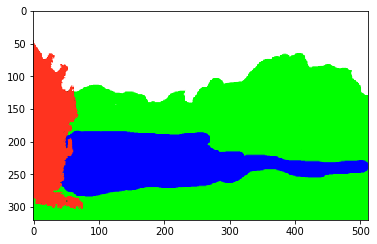

In [14]:
plt.imshow(load_img("data/Renoir/style_mask.png"))

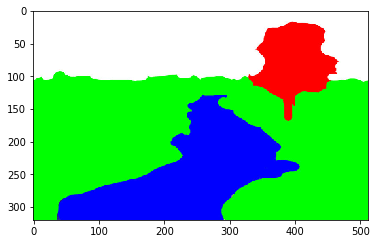

In [15]:
plt.imshow(load_img("data/Renoir/target_mask.png"))

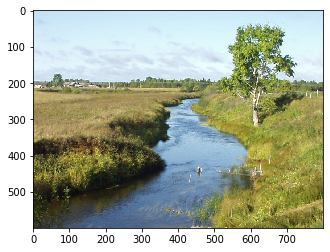

In [16]:
plt.imshow(load_img("data/Renoir/creek.jpg"))

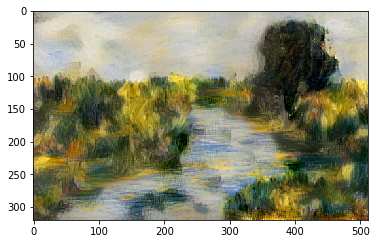

In [17]:
plt.imshow(load_img("results_at_iteration_49.png"))